In [3]:
import pandas as pd
import numpy as np
from scipy import stats

jira_data_all=pd.read_csv("Data/102-108/JIRA Export All fields.csv",low_memory=False)

In [4]:
#Config values
import warnings
warnings.simplefilter("ignore")
devs_look_back_period=2
jiras_look_back_period=4
n_best=20
anonymize_users='y'

In [5]:
if anonymize_users=='y':
    uid_name=pd.read_csv("uid_name_anon.csv")
    print('Using Anonymized names')
else:
    uid_name=pd.read_csv("uid_name.csv")
    
if anonymize_users !='y':
    print(uid_name)

Using Anonymized names


In [6]:
# Retain used columns only from the JIRA dump
col = ['Summary','Issue key','Custom field (Multiple Developers)','Issue Type','Custom field (POD Assignment)','Custom field (Inbound SOR)','Custom field (Target Iteration)','Description'] 
jira_data = jira_data_all[col]
jira_data.columns = ['Summary', 'Issue_key', 'Multiple_Devs','Issue_Type', 'POD','SOR','Iteration','Description']
jira_data.columns

Index(['Summary', 'Issue_key', 'Multiple_Devs', 'Issue_Type', 'POD', 'SOR',
       'Iteration', 'Description'],
      dtype='object')

In [7]:
jira_counts_by_uid=pd.DataFrame(jira_data['Multiple_Devs'].value_counts())
jira_counts_by_uid = jira_counts_by_uid.reset_index()
jira_counts_by_uid.columns = ['Dev_uid', 'counts'] 
jira_counts_by_uid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
Dev_uid    74 non-null object
counts     74 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [8]:
count_by_dev_df=pd.merge(jira_counts_by_uid, uid_name, left_on='Dev_uid', right_on='LOGIN_ID')
count_by_dev_df[['FIRST_NM','counts']].head()

,FIRST_NM,counts
0,Gangaprasad,62
1,Srinivas,50
2,Aniket,37
3,Vamshi,27
4,Ravindra,26


In [9]:
import seaborn as sns
sns.set()

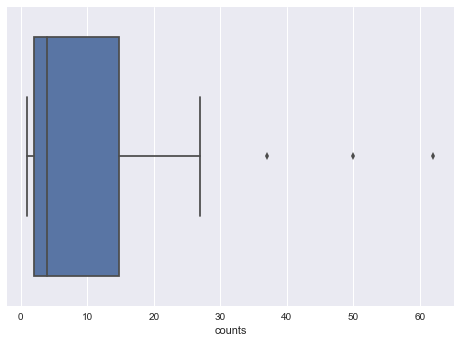

In [10]:
sns.boxplot(data = jira_counts_by_uid,x=jira_counts_by_uid['counts']
            )
import matplotlib.pyplot as plt
plt.show()

In [11]:
z_score = np.abs(stats.zscore(jira_counts_by_uid['counts']))
outliers=np.where(z_score > 3)
outlier_devs=[]
for t in outliers:
	outlier_devs.append(jira_counts_by_uid['Dev_uid'][t])

In [12]:
uid_name[uid_name["LOGIN_ID"].isin(outlier_devs[0])]["FIRST_NM"]

23    Gangaprasad
78       Srinivas
Name: FIRST_NM, dtype: object

In [13]:
jira_data.count()

Summary          727
Issue_key        727
Multiple_Devs    691
Issue_Type       727
POD              607
SOR              631
Iteration        727
Description      727
dtype: int64

In [14]:
jira_data=jira_data[~jira_data["Multiple_Devs"].isin(outlier_devs[0])]
jira_data.count()

Summary          615
Issue_key        615
Multiple_Devs    579
Issue_Type       615
POD              500
SOR              522
Iteration        615
Description      615
dtype: int64

In [15]:
jira_data=pd.merge(jira_data, uid_name, left_on='Multiple_Devs', right_on='LOGIN_ID', how='right')


In [16]:
jira_data=jira_data.drop(['Multiple_Devs','LOGIN_ID'], axis=1)
jira_data.columns = ['Summary', 'Issue_key', 'Issue_Type', 'POD','SOR','Iteration','Description','Name']
jira_data.columns

Index(['Summary', 'Issue_key', 'Issue_Type', 'POD', 'SOR', 'Iteration',
       'Description', 'Name'],
      dtype='object')

In [17]:
#Drop Sourcing JIRAs
jiras_non_sourcing=jira_data[~jira_data['Iteration'].str.contains("Iteration B", na=False)]
# Filter bad data
jiras_non_sourcing=jiras_non_sourcing.dropna()

In [18]:
## Drop JIRA data for Developers that are not current
# Strip 'Iteration ' and convert to number
jiras_non_sourcing['Iteration'] = (jiras_non_sourcing['Iteration'].str[9:]).str.strip().astype('int64')
jiras_non_sourcing.head()

,Summary,Issue_key,Issue_Type,POD,SOR,Iteration,Description,Name
1,FSDF - MIDAS Lonodn & Cayman - Update the logi...,IHUBPS-9404,Enhancement,Securities/Fees/Common,Midas+,104,Update the logic code L-006 for DEP_GL_AMT to ...,Timothy
2,FSDF MIDAS London - Update the mapping for COM...,IHUBPS-9169,Enhancement,Securities/Fees/Common,Midas+,104,Update the mapping for the following balance t...,Timothy
3,CCDMS FSDF- Add Mapping for CUAC_CODE in STG...,IHUBPS-8998,Enhancement,Securities/Fees/Common,CCDMS,103,*{color:#000000}CUAC_CODE :-Denotes the Hogan ...,Timothy
6,Infolease: Mapping Update in TMP_FINANCIALS fo...,IHUBPS-10613,Enhancement,Commercial Cap / Leasing,Infolease,108,Please Refer OLMD:INFOLEASE_8.0.7.1.20 for IT-...,Prasanna
7,Infolease - Update mapping for N_FLOAT_SPREAD ...,IHUBPS-10612,Enhancement,Commercial Cap / Leasing,Infolease,108,Please Refer OLD:INFOLEASE_8.0.7.1.20 for IT-1...,Prasanna


In [19]:
jiras_non_sourcing.count()


Summary        465
Issue_key      465
Issue_Type     465
POD            465
SOR            465
Iteration      465
Description    465
Name           465
dtype: int64

In [20]:
# Format data

jiras_non_sourcing['Name'] = jiras_non_sourcing['Name'].str.title()
jiras_non_sourcing['SOR'] = jiras_non_sourcing['SOR'].str.upper()
jiras_non_sourcing['Summary'] = jiras_non_sourcing['Summary'].str.lower()
jiras_non_sourcing['Description'] = jiras_non_sourcing['Description'].str.lower()


#jiras_non_sourcing['Target Iteration'].max()-4



devs_look_back_iteration=jiras_non_sourcing['Iteration'].max()-devs_look_back_period
devs_look_back_iteration

jira_list_of_active_devs = jiras_non_sourcing[jiras_non_sourcing['Iteration'] > devs_look_back_iteration]

active_developers = jira_list_of_active_devs['Name'].drop_duplicates()
print(active_developers.count())
active_developers


# Drop JIRAs of non-active developers
jira_filtered=jiras_non_sourcing[jiras_non_sourcing['Name'].isin(active_developers)]

#Restrict JIRAs for current allocations
jira_look_back_iteration=jira_filtered['Iteration'].max()-jiras_look_back_period
jira_look_back_iteration

jira_filtered=jiras_non_sourcing[jiras_non_sourcing['Iteration'] > jira_look_back_iteration]

# Drop rows for developers with low number of allocations
jira_filtered=jira_filtered.groupby("Name").filter(lambda x: len(x) > 7)

print(jira_filtered.count())
jira_filtered.head()


30
Summary        121
Issue_key      121
Issue_Type     121
POD            121
SOR            121
Iteration      121
Description    121
Name           121
dtype: int64


,Summary,Issue_key,Issue_Type,POD,SOR,Iteration,Description,Name
6,infolease: mapping update in tmp_financials fo...,IHUBPS-10613,Enhancement,Commercial Cap / Leasing,INFOLEASE,108,please refer olmd:infolease_8.0.7.1.20 for it-...,Prasanna
7,infolease - update mapping for n_float_spread ...,IHUBPS-10612,Enhancement,Commercial Cap / Leasing,INFOLEASE,108,please refer old:infolease_8.0.7.1.20 for it-1...,Prasanna
10,infl - v_int_rate_index_code - data not reflec...,IHUBPS-10297,Defect,Commercial Cap / Leasing,INFOLEASE,106,{color:#172b4d}missed the logic to implement f...,Prasanna
11,infolease - new olmd table stg_dealer_master,IHUBPS-10162,Enhancement,Commercial Cap / Leasing,INFOLEASE,106,*please refer olmd:infolease_8.{color:#333333}...,Prasanna
12,infolease - olmd update for populating private...,IHUBPS-10161,Enhancement,Commercial Cap / Leasing,INFOLEASE,106,*please refer olmd:infolease_8.{color:#333333}...,Prasanna


In [21]:
SOR_distinct = jira_filtered[['SOR']].drop_duplicates().sort_values('SOR')
SOR_distinct.head()


,SOR
126,AFS
56,AIMS
148,BROADRIDGE
149,CCDMS
146,CDD TABLES


In [22]:
from sklearn.preprocessing import LabelBinarizer
encoder1 = LabelBinarizer()
SOR_1hot = encoder1.fit_transform(jira_filtered['SOR'])
print(encoder1.classes_)
encoder2 = LabelBinarizer()
POD_1hot = encoder2.fit_transform(jira_filtered['POD'])
print(encoder2.classes_)
encoder3 = LabelBinarizer()
IssueType_1hot = encoder3.fit_transform(jira_filtered['Issue_Type'])
print(encoder3.classes_)

['AFS' 'AIMS' 'BROADRIDGE' 'CCDMS' 'CDD TABLES' 'EXIMBILLS HK'
 'EXIMBILLS HK INSOURCING' 'GBF' 'IIS' 'INFOLEASE' 'LEASECONNECT (IKNX)'
 'LIQ' 'LUCAS' 'RAILS' 'SHAW/WFDS' 'STRATEGY LOAN SERVICES'
 'SYNTHETIC LEASE' 'TRIP' 'WFA FIRST CLEARING' 'YARDI NMTC']
['Commercial Cap / Leasing' 'Commercial Lending' 'Financial Crimes'
 'Securities/Fees/Common']
['Defect' 'Enhancement' 'Sub-Task - Bug' 'Sub-task' 'Tech Task']


In [23]:
jira_filtered['Iteration'].value_counts()

105    36
108    31
106    30
107    24
Name: Iteration, dtype: int64

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
jira_filtered["Scaled_Iteration"]=scaler.fit_transform(jira_filtered["Iteration"].values.reshape(-1, 1))


In [25]:
print(jira_filtered.count())
jira_filtered.info()

Summary             121
Issue_key           121
Issue_Type          121
POD                 121
SOR                 121
Iteration           121
Description         121
Name                121
Scaled_Iteration    121
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 6 to 372
Data columns (total 9 columns):
Summary             121 non-null object
Issue_key           121 non-null object
Issue_Type          121 non-null object
POD                 121 non-null object
SOR                 121 non-null object
Iteration           121 non-null int64
Description         121 non-null object
Name                121 non-null object
Scaled_Iteration    121 non-null float64
dtypes: float64(1), int64(1), object(7)
memory usage: 14.5+ KB


In [26]:
jira_filtered = jira_filtered.drop(['POD','SOR','Issue_Type','Iteration'], axis=1)

In [27]:
jira_filtered.head()

,Summary,Issue_key,Description,Name,Scaled_Iteration
6,infolease: mapping update in tmp_financials fo...,IHUBPS-10613,please refer olmd:infolease_8.0.7.1.20 for it-...,Prasanna,1.000000
7,infolease - update mapping for n_float_spread ...,IHUBPS-10612,please refer old:infolease_8.0.7.1.20 for it-1...,Prasanna,1.000000
10,infl - v_int_rate_index_code - data not reflec...,IHUBPS-10297,{color:#172b4d}missed the logic to implement f...,Prasanna,0.333333
11,infolease - new olmd table stg_dealer_master,IHUBPS-10162,*please refer olmd:infolease_8.{color:#333333}...,Prasanna,0.333333
12,infolease - olmd update for populating private...,IHUBPS-10161,*please refer olmd:infolease_8.{color:#333333}...,Prasanna,0.333333


In [28]:
jira_filtered['Developer_sk'] = jira_filtered['Name'].factorize()[0]
jira_filtered['Developer_sk'].head(10)

6     0
7     0
10    0
11    0
12    0
13    0
14    0
16    0
20    0
40    1
Name: Developer_sk, dtype: int64

In [29]:
from io import StringIO
developer_id_df = jira_filtered[['Name','Developer_sk']].drop_duplicates().sort_values('Developer_sk')
uid_to_sk = dict(developer_id_df.values)
print(uid_to_sk)
sk_to_uid = dict(developer_id_df[['Developer_sk', 'Name']].values)
print(sk_to_uid)

{'Prasanna': 0, 'Michelle': 1, 'Chirag': 2, 'Vamshi': 3, 'Ravindra': 4, 'Aniket': 5, 'Sudhakar': 6, 'Andrew': 7, 'Brad': 8, 'Satish': 9, 'Vamshee': 10, 'Hafiza': 11}
{0: 'Prasanna', 1: 'Michelle', 2: 'Chirag', 3: 'Vamshi', 4: 'Ravindra', 5: 'Aniket', 6: 'Sudhakar', 7: 'Andrew', 8: 'Brad', 9: 'Satish', 10: 'Vamshee', 11: 'Hafiza'}


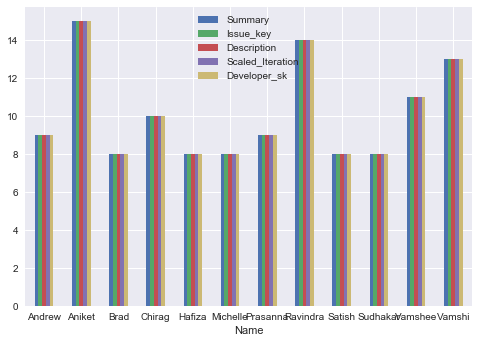

In [30]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,12))
jira_filtered.groupby('Name').count().plot.bar(ylim=0)
plt.xticks(rotation='horizontal')
plt.show()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [32]:
from sklearn.feature_extraction import text 
my_stop_words = text.ENGLISH_STOP_WORDS.union(["please","missed","olmd","column","columns","new","changes","mapping","refer","color",
                                               "issue","logic","join","condition","following","update","processing","following"
                                              ,"update","notes","transformation","updates","updated","filter","conditions"
                                              ,"use","non","conformed","value","add","added","additional","attached","email"
                                              ,"based","case","change","code","codes","current","correct","provide","comments","data","date"
                                              ,"default","implemented","applicable","glimmer","currently","correctly"
                                              ,"l","incorrect","adding","level","record","create","required","different"
                                              ,"target","schema","table","atomic","target ","jira","ihubps","end","populate"
                                               ,"table l","populating","l l","map","note","records","null","n","y","remove"
                                               ,"l remove","loan","left","tables","s","b","include","fields","sor","source"
                                               ,"used","mentioned","substr","mappings","field","fields l","values","details"
                                               ,"populated","flag","fixed","type","standardization","like","e","f","g","mapped"
                                               ,"ihub","needs","removed","replaced","file","sor s","direct","match","types"
                                               ,"y n","information","included","need","trim","forward"
                                              ])


In [33]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=my_stop_words
                       ,token_pattern=r'(?u)\b[A-Za-z]+\b')
features = tfidf.fit_transform(jira_filtered.Summary + jira_filtered.Description).toarray()
labels = jira_filtered.Developer_sk
features.shape

(121, 22)

In [34]:
for key, value in tfidf.vocabulary_.items() :
    print(key)

infolease
guarantor
bqr
strte
aims
io
yardi
cli
reference
contracts
customer
party
yardi cli
fsdf
gbf
shaw
net
afs
cdd
tradeworks
references
lucas


In [35]:

features = np.append(features, jira_filtered.Scaled_Iteration.values.reshape(features.shape[0],1), axis = 1)
features.shape


(121, 23)

In [36]:
features = np.append(features,SOR_1hot, axis = 1)
features = np.append(features,POD_1hot , axis = 1)
features = np.append(features,IssueType_1hot , axis = 1)
features.shape

(121, 52)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

In [38]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, jira_filtered.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

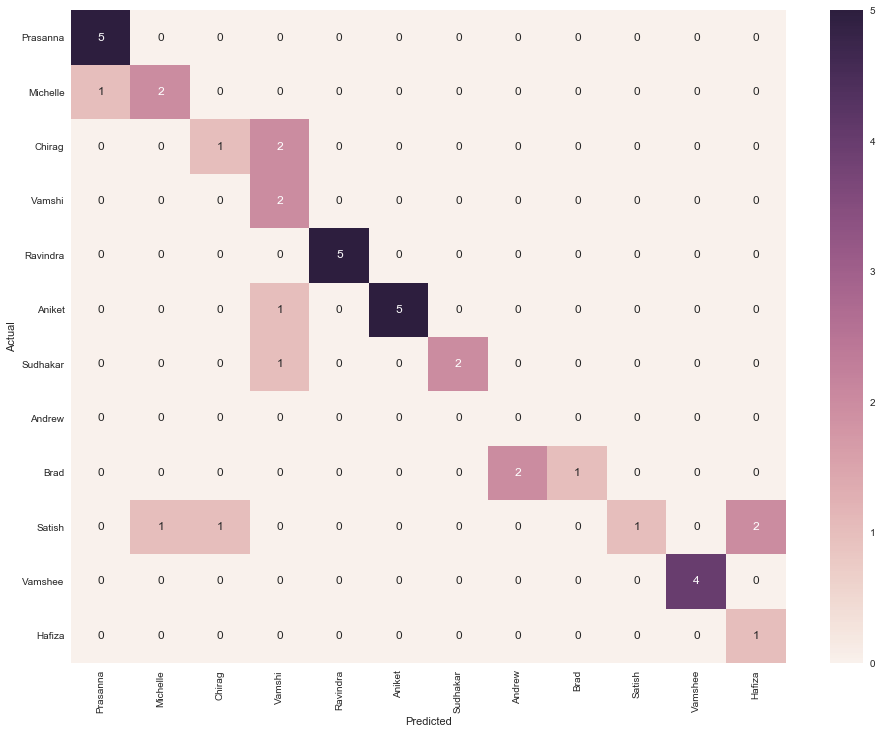

In [39]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=developer_id_df.Name.values, yticklabels=developer_id_df.Name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')
plt.show()

In [40]:
model.fit(features, labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [41]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=jira_filtered['Name'].unique()))

             precision    recall  f1-score   support

   Prasanna       0.83      1.00      0.91         5
   Michelle       0.67      0.67      0.67         3
     Chirag       0.50      0.33      0.40         3
     Vamshi       0.33      1.00      0.50         2
   Ravindra       1.00      1.00      1.00         5
     Aniket       1.00      0.83      0.91         6
   Sudhakar       1.00      0.67      0.80         3
     Andrew       0.00      0.00      0.00         0
       Brad       1.00      0.33      0.50         3
     Satish       1.00      0.20      0.33         5
    Vamshee       1.00      1.00      1.00         4
     Hafiza       0.33      1.00      0.50         1

avg / total       0.87      0.72      0.73        40



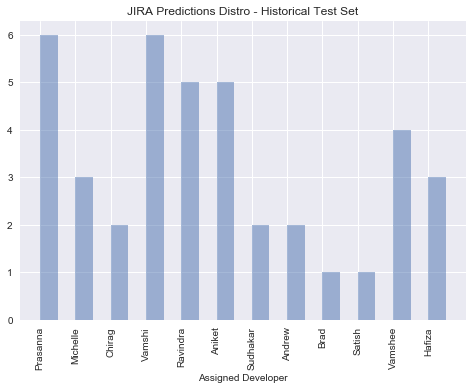

In [42]:
uniqueValues, occurCount = np.unique(y_pred, return_counts=True)
# Zip both the arrays
listOfUniqueValues = zip(uniqueValues, occurCount)

labels=[]
for elem in listOfUniqueValues:
   labels.append(sk_to_uid[elem[0]] )

index=np.arange(len(uniqueValues))
plt.bar(index, occurCount, align='edge', alpha=0.5, width=0.5)
plt.xlabel('Assigned Developer', fontsize=10)
plt.xticks(index, labels,rotation='vertical')
plt.title('JIRA Predictions Distro - Historical Test Set')
plt.show()

In [43]:
# data to predict for
jira_data_next_iteration=pd.read_csv("Data/109/JIRA Export All Fields.csv")

In [44]:
# Retain used columns only from the JIRA dump
col = ['Summary','Issue key','Custom field (Multiple Developers)','Issue Type','Custom field (POD Assignment)','Custom field (Inbound SOR)','Custom field (Target Iteration)','Description'] 
jira_data_pred = jira_data_next_iteration[col]
jira_data_pred.columns = ['Summary', 'Issue_key', 'Multiple_Devs','Issue_Type', 'POD','SOR','Iteration','Description']
jira_data_pred.columns

Index(['Summary', 'Issue_key', 'Multiple_Devs', 'Issue_Type', 'POD', 'SOR',
       'Iteration', 'Description'],
      dtype='object')

In [45]:
jira_data_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
Summary          129 non-null object
Issue_key        129 non-null object
Multiple_Devs    120 non-null object
Issue_Type       129 non-null object
POD              99 non-null object
SOR              106 non-null object
Iteration        129 non-null object
Description      129 non-null object
dtypes: object(8)
memory usage: 8.1+ KB


In [46]:
jira_data_pred['SOR'] = jira_data_pred['SOR'].str.upper()
jira_data_pred['Summary'] = jira_data_pred['Summary'].str.lower()
jira_data_pred['Description'] = jira_data_pred['Description'].str.lower()


In [47]:
#jira_data_pred=jira_data_pred.dropna()
# use fillna
jira_data_pred["SOR"].fillna("No SOR", inplace = True) 
SOR_1hot_pred = encoder1.transform(jira_data_pred['SOR'])
print(encoder1.classes_)

jira_data_pred["POD"].fillna("No POD", inplace = True) 
POD_1hot_pred = encoder2.transform(jira_data_pred['POD'])
print(encoder2.classes_)

jira_data_pred["Issue_Type"].fillna("No Issue_Type", inplace = True) 
IssueType_1hot_pred = encoder3.transform(jira_data_pred['Issue_Type'])
print(encoder3.classes_)


['AFS' 'AIMS' 'BROADRIDGE' 'CCDMS' 'CDD TABLES' 'EXIMBILLS HK'
 'EXIMBILLS HK INSOURCING' 'GBF' 'IIS' 'INFOLEASE' 'LEASECONNECT (IKNX)'
 'LIQ' 'LUCAS' 'RAILS' 'SHAW/WFDS' 'STRATEGY LOAN SERVICES'
 'SYNTHETIC LEASE' 'TRIP' 'WFA FIRST CLEARING' 'YARDI NMTC']
['Commercial Cap / Leasing' 'Commercial Lending' 'Financial Crimes'
 'Securities/Fees/Common']
['Defect' 'Enhancement' 'Sub-Task - Bug' 'Sub-task' 'Tech Task']


In [48]:
jira_data_pred['Iteration'] = (jira_data_pred['Iteration'].str[9:]).str.strip().astype('int64')

jira_data_pred['Scaled_Iteration']=scaler.transform(jira_data_pred["Iteration"].values.reshape(-1, 1))

features_pred = tfidf.transform(jira_data_pred.Summary +jira_data_pred.Description).toarray()

features_pred.shape

(129, 22)

In [49]:
features_pred = np.append(features_pred, jira_data_pred.Scaled_Iteration.values.reshape(features_pred.shape[0],1), axis = 1)
features_pred.shape

(129, 23)

In [50]:

features_pred = np.append(features_pred,SOR_1hot_pred, axis = 1)
features_pred = np.append(features_pred,POD_1hot_pred , axis = 1)
features_pred = np.append(features_pred,IssueType_1hot_pred , axis = 1)

features_pred.shape

(129, 52)

In [51]:
y_pred_next_iteration = model.predict(features_pred)

In [52]:
#predicted_developers=pd.DataFrame(y_pred_next_iteration,columns=['Predicted_Developer'])[0].map(sk_to_uid)
predicted_developers=pd.DataFrame(y_pred_next_iteration,columns=['Predicted_Developer'])


In [53]:
predicted_developers=predicted_developers['Predicted_Developer'].map(sk_to_uid)

In [54]:
jira_predictions=pd.concat([jira_data_pred[["Summary","Issue_key"]], predicted_developers],axis=1)

In [55]:
jira_predictions.head()
#jira_predictions.to_excel("jira_predictions.xlsx",sheet_name='jira_predicted_dev',index=False)

,Summary,Issue_key,Predicted_Developer
0,oth implementation correction for sy for accou...,IHUBPS-11232,Vamshi
1,sourcing prt scheduling changes,IHUBPS-11216,Aniket
2,use of reusable sequence generator for strte a...,IHUBPS-11187,Hafiza
3,remove unused infolease table entries,IHUBPS-11185,Aniket
4,stg_wf_cntrct_prstnt_key changes for v_data_or...,IHUBPS-11089,Aniket


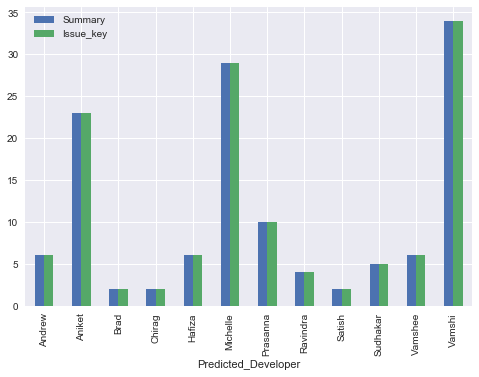

In [56]:
fig = plt.figure(figsize=(16,12))
jira_predictions.groupby('Predicted_Developer').count().plot.bar(ylim=0)
plt.xticks(rotation='vertical')
plt.show()

In [57]:
probability = model.predict_proba(features_pred)

In [58]:
print(probability)

[[ 0.03157049  0.10609123  0.03379352 ...,  0.02531732  0.0187342
   0.07398942]
 [ 0.03546799  0.12019077  0.04076321 ...,  0.03060364  0.02157475
   0.08596545]
 [ 0.0305953   0.14906867  0.03259022 ...,  0.02917956  0.01847843
   0.21378922]
 ..., 
 [ 0.02694778  0.04595638  0.03569155 ...,  0.01942517  0.01370765
   0.09251289]
 [ 0.02751238  0.15087763  0.06788408 ...,  0.04300025  0.02239455
   0.08754095]
 [ 0.0217629   0.03658622  0.02401338 ...,  0.01502456  0.01107735
   0.06867179]]


In [59]:
print(np.size(probability,axis=0))
print(np.size(model.classes_))

129
12


In [60]:

class_proba=(sorted( zip( model.classes_, probability[0] ), key=lambda x:x[1], reverse=True)[:n_best])
#print(np.array(sorted( zip( model.classes_, probability[0] ), key=lambda x:x[1], reverse=True)[:1]))
print(type(class_proba))
np.size(class_proba,axis=0)
for dev,proba in class_proba:
    print("Dev" , dev , "Probability is" , proba)


<class 'list'>
Dev 3 Probability is 0.245326658373
Dev 5 Probability is 0.20248744
Dev 1 Probability is 0.10609122679
Dev 8 Probability is 0.0935132007853
Dev 7 Probability is 0.0822457745133
Dev 11 Probability is 0.0739894167715
Dev 4 Probability is 0.0538797551144
Dev 2 Probability is 0.0337935155317
Dev 6 Probability is 0.0330509940494
Dev 0 Probability is 0.031570490972
Dev 9 Probability is 0.0253173235219
Dev 10 Probability is 0.0187342035765


In [61]:
dev_bestproba_list=np.zeros(shape=(np.size(probability,axis=0),n_best*2))

i=0
for row in probability:
    #print((np.asarray(sorted( zip( model.classes_, probability[i] ), key=lambda x:x[1], reverse=True)[:1])))
    class_proba=(sorted( zip( model.classes_, probability[i] ), key=lambda x:x[1], reverse=True)[:n_best])
    if i==0:
        print(class_proba)
    k=0
    for dev,proba in class_proba:
        
        dev_bestproba_list[i][k*2]=int(class_proba[k][0])
        dev_bestproba_list[i][(k*2+1)]=class_proba[k][1]
        if i==0 and k==0:
            print(k, dev_bestproba_list[0])
        k+=1
        
    i+=1
    
print(dev_bestproba_list[0])

[(3, 0.24532665837341894), (5, 0.20248744000028043), (1, 0.10609122679040479), (8, 0.093513200785268383), (7, 0.082245774513282244), (11, 0.073989416771466435), (4, 0.05387975511436302), (2, 0.033793515531694802), (6, 0.033050994049388341), (0, 0.031570490972031739), (9, 0.02531732352188306), (10, 0.018734203576517859)]
0 [ 3.          0.24532666  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
[  3.           0.24532666   5.           0.20248744   1.           0.10609123
   8.           0.0935132    7.           0.08224577  11.           0.07398942
   4.           0.05387976   2.           0.03379352   6.           0.0

In [62]:
col_list = []
for i in range(n_best):
   col_list = col_list +  ["Dev_" + str(i+1) ] + ["Proba_" + str(i+1) ] 

dev_bestproba_df=pd.DataFrame(dev_bestproba_list)
dev_bestproba_df.columns=[col_list]

dev_bestproba_df.head()



,Dev_1,Proba_1,Dev_2,Proba_2,Dev_3,Proba_3,Dev_4,Proba_4,Dev_5,Proba_5,...,Dev_16,Proba_16,Dev_17,Proba_17,Dev_18,Proba_18,Dev_19,Proba_19,Dev_20,Proba_20
0,3.0,0.245327,5.0,0.202487,1.0,0.106091,8.0,0.093513,7.0,0.082246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.187093,3.0,0.180333,1.0,0.120191,8.0,0.102404,7.0,0.093247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11.0,0.213789,5.0,0.157779,1.0,0.149069,3.0,0.143776,8.0,0.079511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.0,0.172789,3.0,0.153215,0.0,0.138455,1.0,0.138256,8.0,0.097431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.179316,3.0,0.156598,2.0,0.118316,8.0,0.100814,1.0,0.096320,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
for i in range(n_best):
    col_to_check="Dev_" + str(i+1)
    if col_to_check in dev_bestproba_df.columns:
        dev_bestproba_df[col_to_check]=dev_bestproba_df[col_to_check].map(sk_to_uid)

dev_bestproba_df.head()

,Dev_1,Proba_1,Dev_2,Proba_2,Dev_3,Proba_3,Dev_4,Proba_4,Dev_5,Proba_5,...,Dev_16,Proba_16,Dev_17,Proba_17,Dev_18,Proba_18,Dev_19,Proba_19,Dev_20,Proba_20
0,Vamshi,0.245327,Aniket,0.202487,Michelle,0.106091,Brad,0.093513,Andrew,0.082246,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
1,Aniket,0.187093,Vamshi,0.180333,Michelle,0.120191,Brad,0.102404,Andrew,0.093247,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
2,Hafiza,0.213789,Aniket,0.157779,Michelle,0.149069,Vamshi,0.143776,Brad,0.079511,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
3,Aniket,0.172789,Vamshi,0.153215,Prasanna,0.138455,Michelle,0.138256,Brad,0.097431,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
4,Aniket,0.179316,Vamshi,0.156598,Chirag,0.118316,Brad,0.100814,Michelle,0.096320,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0


In [64]:
jira_df= pd.DataFrame(jira_data_pred['Issue_key'].values)
jira_df.columns=['Issue_key']
jira_dev_df=pd.concat([jira_df, dev_bestproba_df], axis=1)
jira_dev_df.head()

,Issue_key,Dev_1,Proba_1,Dev_2,Proba_2,Dev_3,Proba_3,Dev_4,Proba_4,Dev_5,...,Dev_16,Proba_16,Dev_17,Proba_17,Dev_18,Proba_18,Dev_19,Proba_19,Dev_20,Proba_20
0,IHUBPS-11232,Vamshi,0.245327,Aniket,0.202487,Michelle,0.106091,Brad,0.093513,Andrew,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
1,IHUBPS-11216,Aniket,0.187093,Vamshi,0.180333,Michelle,0.120191,Brad,0.102404,Andrew,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
2,IHUBPS-11187,Hafiza,0.213789,Aniket,0.157779,Michelle,0.149069,Vamshi,0.143776,Brad,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
3,IHUBPS-11185,Aniket,0.172789,Vamshi,0.153215,Prasanna,0.138455,Michelle,0.138256,Brad,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
4,IHUBPS-11089,Aniket,0.179316,Vamshi,0.156598,Chirag,0.118316,Brad,0.100814,Michelle,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0


In [65]:
jira_dev_df=jira_dev_df.sort_values(['Dev_1','Proba_1'], ascending=[1,0])
jira_dev_df.head()

,Issue_key,Dev_1,Proba_1,Dev_2,Proba_2,Dev_3,Proba_3,Dev_4,Proba_4,Dev_5,...,Dev_16,Proba_16,Dev_17,Proba_17,Dev_18,Proba_18,Dev_19,Proba_19,Dev_20,Proba_20
91,IHUBPS-10509,Andrew,0.396049,Brad,0.205887,Ravindra,0.182596,Michelle,0.057592,Vamshi,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
47,IHUBPS-10748,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
94,IHUBPS-10475,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
102,IHUBPS-10372,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0
103,IHUBPS-10319,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0


In [66]:
jira_dev_df['jira_seq'] = jira_dev_df.groupby('Dev_1')['Proba_1'].rank(method="first", ascending=False)


In [67]:
col = ['Issue_key','Dev_1','Proba_1','jira_seq'] 
jira_dev_seq_df = jira_dev_df[col]
jira_dev_seq_df.head()


,Issue_key,Dev_1,Proba_1,jira_seq
91,IHUBPS-10509,Andrew,0.396049,1.0
47,IHUBPS-10748,Andrew,0.390691,2.0
94,IHUBPS-10475,Andrew,0.390691,3.0
102,IHUBPS-10372,Andrew,0.390691,4.0
103,IHUBPS-10319,Andrew,0.390691,5.0


In [68]:
total_jira_issues=jira_dev_seq_df.Issue_key.count()
total_developers=jira_dev_seq_df.Dev_1.nunique()
avg_jiras_per_dev=(total_jira_issues/total_developers).round()

overloaded_jira_dev=jira_dev_seq_df.loc[jira_dev_seq_df['jira_seq'] > avg_jiras_per_dev]
overloaded_jira_dev.Dev_1.value_counts()


Vamshi      23
Michelle    18
Aniket      12
Name: Dev_1, dtype: int64

In [69]:
all_counts=pd.DataFrame(jira_dev_seq_df['Dev_1'].value_counts())
all_counts

,Dev_1
Vamshi,34
Michelle,29
Aniket,23
Prasanna,10
Vamshee,6
Andrew,6
Hafiza,6
Sudhakar,5
Ravindra,4
Brad,2


In [70]:
overloaded_developers=overloaded_jira_dev['Dev_1'].unique()

print(type(overloaded_developers))
(overloaded_developers)

<class 'numpy.ndarray'>


array(['Aniket', 'Michelle', 'Vamshi'], dtype=object)

In [71]:
underloaded_jira_dev=jira_dev_seq_df.loc[jira_dev_seq_df['jira_seq'] < avg_jiras_per_dev]
print(type(underloaded_jira_dev.Dev_1.value_counts()))

<class 'pandas.core.series.Series'>


In [72]:
underloaded_counts=pd.DataFrame(underloaded_jira_dev['Dev_1'].value_counts())
underloaded_counts = underloaded_counts.reset_index()
underloaded_counts.columns = ['Dev', 'counts'] 

In [73]:
(underloaded_counts)

,Dev,counts
0,Prasanna,10
1,Aniket,10
2,Vamshi,10
3,Michelle,10
4,Vamshee,6
5,Andrew,6
6,Hafiza,6
7,Sudhakar,5
8,Ravindra,4
9,Brad,2


In [74]:
jira_reassign=overloaded_jira_dev['Issue_key'].dropna()
jira_reassign.head()

44     IHUBPS-10763
48     IHUBPS-10733
62     IHUBPS-10605
105    IHUBPS-10275
4      IHUBPS-11089
Name: Issue_key, dtype: object

In [75]:
#jira_dev_df=jira_dev_df.drop(['jira_seq'],axis=1)
jira_dev_df.reset_index(drop=True, inplace=True)
jira_dev_df.head()


,Issue_key,Dev_1,Proba_1,Dev_2,Proba_2,Dev_3,Proba_3,Dev_4,Proba_4,Dev_5,...,Proba_16,Dev_17,Proba_17,Dev_18,Proba_18,Dev_19,Proba_19,Dev_20,Proba_20,jira_seq
0,IHUBPS-10509,Andrew,0.396049,Brad,0.205887,Ravindra,0.182596,Michelle,0.057592,Vamshi,...,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,1.0
1,IHUBPS-10748,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,2.0
2,IHUBPS-10475,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,3.0
3,IHUBPS-10372,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,4.0
4,IHUBPS-10319,Andrew,0.390691,Brad,0.247305,Ravindra,0.192039,Michelle,0.049290,Vamshi,...,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,Prasanna,0.0,5.0


In [76]:
total_reassignment_count=0

for i in range(n_best):
    loop_reassignment_count=0
    jira_count=0
    for jira_item in jira_reassign.iteritems(): 
        row_to_shift = jira_dev_df[jira_dev_df.Issue_key == jira_item[1]]
        row_index_to_shift = row_to_shift.index
                
        row_to_shift=((jira_dev_df.iloc[row_index_to_shift,:-1]))


        Dev1=(row_to_shift['Dev_1']).values[0]
        Dev2=(row_to_shift['Dev_2']).values[0]
        
        #Dev1 is overloaded but Dev2 is not
        if np.in1d(Dev1, list(overloaded_developers)) and Dev2 and not np.in1d(Dev2, list(overloaded_developers)) :
            jira_dev_df.iloc[row_index_to_shift,1:-1] = jira_dev_df.iloc[row_index_to_shift,1:-1].shift(periods=-1,axis=1)
            jira_dev_df['jira_seq'] = jira_dev_df.groupby('Dev_1')['Proba_1'].rank(method="first", ascending=False)
            print('Replacing ', Dev1, 'with ', Dev2 , 'for JIRA ',jira_item[1] )
            total_reassignment_count+=1
            loop_reassignment_count+=1

        #Dev1 and Dev2 both are overloaded 

        if np.in1d(Dev1, list(overloaded_developers)) and Dev2 and np.in1d(Dev2, list(overloaded_developers)) :
            jira_dev_df.iloc[row_index_to_shift,3:] = jira_dev_df.iloc[row_index_to_shift,3:].shift(periods=-1,axis=1)

        jira_count+=1

        overloaded_jira_dev=jira_dev_df.loc[jira_dev_df['jira_seq'] > avg_jiras_per_dev]
        overloaded_jira_dev.Dev_1.value_counts()
        overloaded_developers=overloaded_jira_dev['Dev_1'].unique()
        #print(overloaded_developers)
        
    print('Reassigned ', loop_reassignment_count)

        

print('jira_count=',jira_count)
print('total_reassignment_count=',total_reassignment_count)


Replacing  Aniket with  Andrew for JIRA  IHUBPS-11037
Replacing  Aniket with  Andrew for JIRA  IHUBPS-10806
Replacing  Aniket with  Andrew for JIRA  IHUBPS-10804
Replacing  Aniket with  Andrew for JIRA  IHUBPS-10803
Replacing  Aniket with  Andrew for JIRA  IHUBPS-10560
Replacing  Aniket with  Andrew for JIRA  IHUBPS-10416
Replacing  Michelle with  Satish for JIRA  IHUBPS-10647
Replacing  Michelle with  Satish for JIRA  IHUBPS-10583
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10862
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10849
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10602
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10594
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10527
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-10507
Replacing  Michelle with  Ravindra for JIRA  IHUBPS-9321
Replacing  Michelle with  Hafiza for JIRA  IHUBPS-10543
Replacing  Michelle with  Hafiza for JIRA  IHUBPS-10395
Replacing  Michelle with  Hafiza for JIRA  IHUB

In [77]:
all_counts=pd.DataFrame(jira_dev_df['Dev_1'].value_counts())
all_counts

,Dev_1
Ravindra,11
Michelle,11
Sudhakar,11
Brad,11
Vamshi,11
Andrew,11
Prasanna,11
Satish,11
Aniket,11
Hafiza,11


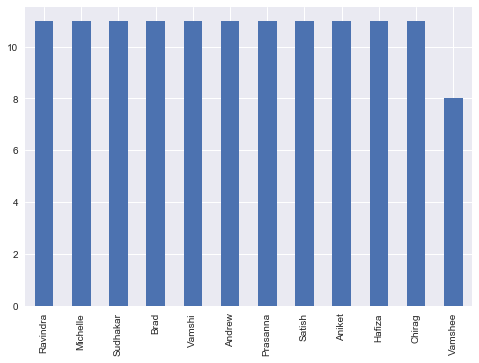

In [78]:
jira_dev_df['Dev_1'].value_counts().plot(kind='bar')
plt.show()

Deployment

In [79]:
from sklearn.externals import joblib

joblib.dump(value=model,filename='jira_model.pkl')

['jira_model.pkl']

In [81]:
joblib.dump(value=encoder1,filename='encoder1.pkl')
joblib.dump(value=encoder2,filename='encoder2.pkl')
joblib.dump(value=encoder3,filename='encoder3.pkl')
joblib.dump(value=scaler,filename='scaler.pkl')
joblib.dump(value=tfidf,filename='tfidf.pkl')



['tfidf.pkl']

In [83]:
import os
data_folder = os.path.join(os.getcwd(), 'Data/110')
jira_data_next_iteration=pd.read_csv(os.path.join(data_folder, 'JIRA Export All Fields.csv'))

# Retain used columns only from the JIRA dump
col = ['Summary','Issue key','Custom field (Multiple Developers)','Issue Type','Custom field (POD Assignment)','Custom field (Inbound SOR)','Custom field (Target Iteration)','Description'] 
jira_data_pred = jira_data_next_iteration[col]
jira_data_pred.columns = ['Summary', 'Issue_key', 'Multiple_Devs','Issue_Type', 'POD','SOR','Iteration','Description']
jira_data_pred.columns
jira_data_pred['SOR'] = jira_data_pred['SOR'].str.upper()
jira_data_pred['Summary'] = jira_data_pred['Summary'].str.lower()
jira_data_pred['Description'] = jira_data_pred['Description'].str.lower()

jira_data_pred["SOR"].fillna("No SOR", inplace = True) 
SOR_1hot_pred = encoder1.transform(jira_data_pred['SOR'])
jira_data_pred["POD"].fillna("No POD", inplace = True) 
POD_1hot_pred = encoder2.transform(jira_data_pred['POD'])
jira_data_pred["Issue_Type"].fillna("No Issue_Type", inplace = True) 
IssueType_1hot_pred = encoder3.transform(jira_data_pred['Issue_Type'])
jira_data_pred['Iteration'] = (jira_data_pred['Iteration'].str[9:]).str.strip().astype('int64')

jira_data_pred['Scaled_Iteration']=scaler.transform(jira_data_pred["Iteration"].values.reshape(-1, 1))


features_pred = tfidf.transform(jira_data_pred.Summary +jira_data_pred.Description).toarray()
features_pred = np.append(features_pred, jira_data_pred.Scaled_Iteration.values.reshape(features_pred.shape[0],1), axis = 1)

features_pred = np.append(features_pred,SOR_1hot_pred, axis = 1)
features_pred = np.append(features_pred,POD_1hot_pred , axis = 1)
features_pred = np.append(features_pred,IssueType_1hot_pred , axis = 1)

In [85]:
y_hat = model.predict(features_pred)
print(y_hat)

[ 7  7  3  3  5  3  3  7  3  3  5  3  3  3  3  3 11 11  6  3  7  3  2  3  3
 11  0 10 10  0  1  3  3  1  1  3  1  3  3  3  3  3 10  3  6  3 10  7  3  1
  0  3  3  3  3  4  7 11  7  3  3  7  3  0  7  0  3  3  3  3  3  3  3  3  3
  3  1  1 10  7  7  3  8  4  7 10 10 10  3  1  3 11 11  3  1  1  1  1 11  1
 11  2  7  7  1  2  4  1  5  3  0  1  3  3  5  3  8  6  3  3  3  7  3  7  3
  3  3  3  1  1  3  3  3  3  1  3  3  8  3  1  8  3  3  1  3 11  8  1  1  1
  3  8  1  3  3  8]
